# Notebook to compute the similarity between two cell types

Last updated: 4/10/2023


In [264]:
import os
import sys
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# import modules for computing the similarity metrics (between two cells)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number
mpl.rcParams['pdf.fonttype'] = 42

# Use "Computer Modern" (LaTeX font) for math numbers
# mpl.rcParams['mathtext.fontset'] = 'cm'
# %matplotlib inline
# change font (for texts)
# mpl.rcParams['font.sans-serif'] = "Arial"
# mpl.rcParams['font.family'] = "sans-serif"

sns.set(style='whitegrid', context='paper')

# ignore warnings regarding fonts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [262]:
set_plotting_style()

In [2]:
# load utilities module
import sys
sys.path.append("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/utilities/")
import color_schema

In [274]:
# define the figure path
figpath = "/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_ATAC_multiome/"
sc.settings.figdir = figpath
# set_plotting_style()

In [410]:
adata_test = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v6.h5ad")
adata_test

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05'
    var: 'assay'
    uns: 'ATAC', 'ATAC_leiden_015_colors', 'ATAC_leiden_05_colors', 'GEX_leiden_015_colors', 'GEX_leiden_05_colors', 'RNA', 'cell_type_colors', 'joint_leiden_015_colors', 'joint_leiden_025_colors', 'joint_leiden_05_colors', 'leiden', 'manual_annotation_B_fine_colors', 'neighbors', 'pca', 'umap'
    obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap_WNN_seurat'
    varm: 'PCs'
    obsp: 'ATAC_connecti

In [204]:
# load the anndata
# adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/multiome_BMMC_processed.h5ad")
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v7.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05'
    var: 'assay'
    uns: 'ATAC', 'ATAC_leiden_05_colors', 'GEX_leiden_05_colors', 'RNA', 'cell_type_colors', 'leiden'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'ATAC_connectivities', 'ATAC_distances', 'RNA_connectivities', 'RNA_distances', 'WNN_connectivities', 'connectivities', 'distances'

In [205]:
rows = len(adata.obsm["X_lsi_red"])
cols = len(adata.obsm["X_lsi_red"][0])
print((rows, cols))

(6224, 38)


# Subset the B cell subtypes then compute the similarity metrics using dim.reduction

- We will subset the data for B cell subtypes (B1 B, CD20+ Naive B, Transitional B)
- Then, we will compute the similarity metrics using PC/LSI (dimensionality reduction methods used for RNA and ATAC, respectively).
- There can be multiple similiarity metrics, such as (1) cosine similiarity, (2) correlation, (3) euclidean distance. We will start with the cosine similarity.
- Alternative is to compute the similarity metrics using the log-normalized counts from RNA and ATAC, respectively. For this, be careful for the ATAC, as we need to use the "peaks", not the "mapped genes", which is a prediction (from Signac).

In [355]:
# markers_RNA = {'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
#                 'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 
#                          'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 
#                          'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
#                 'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2']}

# markers_ATAC = {'Naive CD20+ B': ['MS4A1', 'LYN', 'CD74', 'BLK'],
#                 'B1 B': ['ITGB1', 'MS4A1', 'DUSP22', 'EPHA4'],
#                 'Transitional B': ['MME', 'CD38', 'CD24'],}

In [208]:
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05'
    var: 'assay'
    uns: 'ATAC', 'ATAC_leiden_05_colors', 'GEX_leiden_05_colors', 'RNA', 'cell_type_colors', 'leiden'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'ATAC_connectivities', 'ATAC_distances', 'RNA_connectivities', 'RNA_distances', 'WNN_connectivities', 'connectivities', 'distances'

In [206]:
# import the weights from WNN (Seurat v4)
weights = pd.read_csv("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/wnn_weights.csv", 
                      index_col=[0])
weights

,SCT.weight,ATAC.weight
AAACAGCCAATTAAGG-1,0.477570,0.522430
AAACAGCCAGGCTGTT-1,0.579224,0.420776
AAACATGCAAAGCGCA-1,0.580633,0.419367
AAACATGCAATAACCT-1,0.400453,0.599547
AAACATGCAATAATGG-1,0.445056,0.554944
...,...,...
TTTGTGTTCATGTGGT-1,0.500768,0.499232
TTTGTGTTCATTTGCT-1,0.708056,0.291944
TTTGTGTTCGCCTAAG-1,0.397656,0.602344
TTTGTTGGTACGGTAC-1,0.382757,0.617243


In [235]:
adata.obsm["wnn_weights"] = weights

In [207]:
weights_RNA = weights.loc[:,"SCT.weight"].to_numpy().reshape((-1,1))
weights_ATAC = weights.loc[:,"ATAC.weight"].to_numpy().reshape((-1,1))

In [209]:
PCA_LSI_wnn = np.concatenate((adata.obsm["X_pca_RNA"] *weights_RNA, adata.obsm["X_lsi_red"]*weights_ATAC), axis=1)
PCA_LSI_wnn

array([[-1.53336239, -1.74501411,  0.10301866, ...,  0.07886431,
         0.12861772,  0.19628254],
       [-0.78896388, -0.13614218, -1.10212246, ...,  0.07283554,
        -0.25286872,  0.0595845 ],
       [-2.44491625, -2.5140799 ,  0.62008722, ...,  0.25329896,
        -0.11051612, -0.1717796 ],
       ...,
       [-1.27041395, -1.29616387,  0.37455286, ..., -0.05306121,
        -0.0411253 ,  0.15877684],
       [-1.12813911, -1.14705026,  0.57418783, ...,  0.07910429,
         0.10625339,  0.02605009],
       [-1.96838019, -1.48776182,  1.15597785, ...,  0.03041204,
         0.19536007, -0.13204961]])

In [210]:
# save the concatenated dataframe (PCA:LSI with weights) in adata.obsm
adata.obsm["X_wnn_pca_lsi"] = PCA_LSI_wnn

In [211]:
adata.obsm

AxisArrays with keys: X_lsi_full, X_lsi_red, X_pca_RNA, X_umap_ATAC, X_umap_RNA, X_wnn_pca_lsi

In [213]:
# subset the B cell subtype populations
B1_B = adata[adata.obs["manual_annotation_B_fine"]=="B1 B"]
CD20_B = adata[adata.obs["manual_annotation_B_fine"]=="Naive CD20+ B"]
Trans_B = adata[adata.obs["manual_annotation_B_fine"]=="Transitional B"]


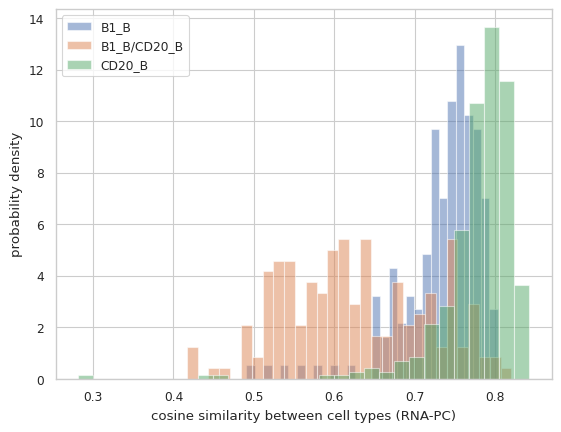

In [285]:
# Calculate cosine similarity using the PCs used to generate the RNA umap (RNA)

# B1_B vs CD20+B
B1_B_RNA = B1_B.obsm["X_pca_RNA"]
CD20_B_RNA = CD20_B.obsm["X_pca_RNA"]
Trans_B_RNA = Trans_B.obsm["X_pca_RNA"]

# compute the cosine similarity
B1_B_cosine = cosine_similarity(B1_B_RNA, B1_B_RNA).mean(axis=1)
B1_B_CD20_B_cosine = cosine_similarity(B1_B_RNA, CD20_B_RNA).mean(axis=1)
CD20_B_cosine = cosine_similarity(CD20_B_RNA, CD20_B_RNA).mean(axis=1)

# B1_B_cosine = np.ravel(np.triu(B1_B_cosine, k=1))
# B1_B_CD20_B_cosine = np.ravel(np.triu(B1_B_CD20_B_cosine, k=1))
# CD20_B_cosine = np.ravel(np.triu(CD20_B_cosine, k=1))



# Panel A
bins = np.linspace(-0.2, 0.9, 30)
bins=30
# ax = axes[0,0]
plt.hist(B1_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_cosine, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (RNA-PC)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_cosine_sim_Bcells_pca.pdf")

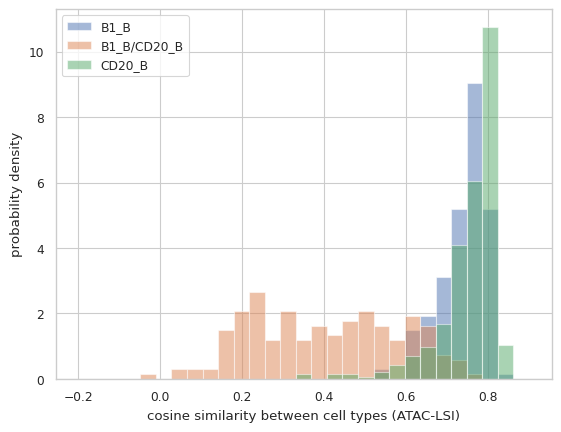

In [276]:
# Calculate cosine similarity using the LSIs used to generate the ATAC umap (ATAC)

# B1_B vs CD20+B
B1_B_ATAC = B1_B.obsm["X_lsi_red"]
CD20_B_ATAC = CD20_B.obsm["X_lsi_red"]
Trans_B_ATAC = Trans_B.obsm["X_lsi_red"]

B1_B_cosine = cosine_similarity(B1_B_ATAC, B1_B_ATAC).mean(axis=1)
B1_B_CD20_B_cosine = cosine_similarity(B1_B_ATAC, CD20_B_ATAC).mean(axis=1)
CD20_B_cosine = cosine_similarity(CD20_B_ATAC, CD20_B_ATAC).mean(axis=1)

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
#bins=30
# ax = axes[0,0]
plt.hist(B1_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_cosine, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (ATAC-LSI)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_cosine_sim_Bcells_lsi.pdf")

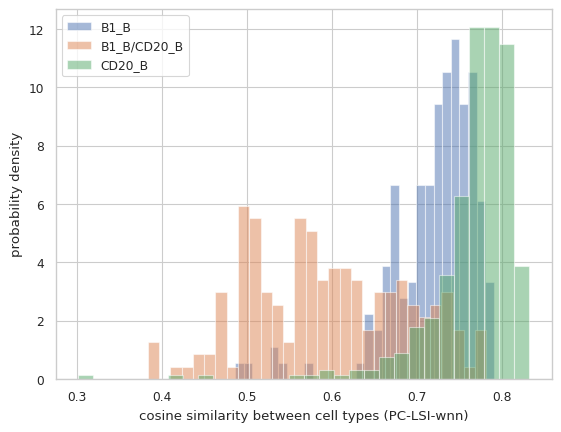

In [284]:
# Calculate cosine similarity using the weighted combination of PCs and LSIs used to generate the joint WNN umap (WNN)

# B1_B vs CD20+B
B1_B_wnn = B1_B.obsm["X_wnn_pca_lsi"]
CD20_B_wnn = CD20_B.obsm["X_wnn_pca_lsi"]
Trans_B_wnn = Trans_B.obsm["X_wnn_pca_lsi"]

B1_B_cosine = cosine_similarity(B1_B_wnn, B1_B_wnn).mean(axis=1)
B1_B_CD20_B_cosine = cosine_similarity(B1_B_wnn, CD20_B_wnn).mean(axis=1)
CD20_B_cosine = cosine_similarity(CD20_B_wnn, CD20_B_wnn).mean(axis=1)

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
bins=30
# ax = axes[0,0]
plt.hist(B1_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_cosine, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (PC-LSI-wnn)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_cosine_sim_Bcells_pca+lsi.pdf")


## euclidean distance

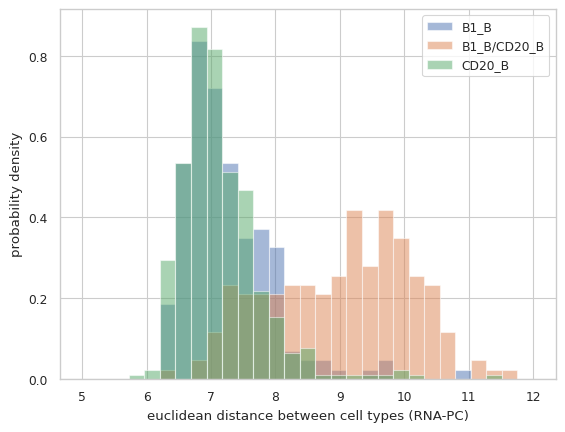

In [278]:
# Calculate euclidean distance using the PCs used to generate the RNA umap (RNA)

# B1_B vs CD20+B
B1_B_RNA = B1_B.obsm["X_pca_RNA"]
CD20_B_RNA = CD20_B.obsm["X_pca_RNA"]
Trans_B_RNA = Trans_B.obsm["X_pca_RNA"]

# compute the euclidean distance
B1_B_dist = euclidean_distances(B1_B_RNA, B1_B_RNA).mean(axis=1)
B1_B_CD20_B_dist = euclidean_distances(B1_B_RNA, CD20_B_RNA).mean(axis=1)
CD20_B_dist = euclidean_distances(CD20_B_RNA, CD20_B_RNA).mean(axis=1)

# B1_B_cosine = np.ravel(np.triu(B1_B_cosine, k=1))
# B1_B_CD20_B_cosine = np.ravel(np.triu(B1_B_CD20_B_cosine, k=1))
# CD20_B_cosine = np.ravel(np.triu(CD20_B_cosine, k=1))



# Panel A
bins = np.linspace(5, 12, 30)
#bins=30
# ax = axes[0,0]
plt.hist(B1_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_dist, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('euclidean distance between cell types (RNA-PC)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_euclid_dist_Bcells_pca.pdf")

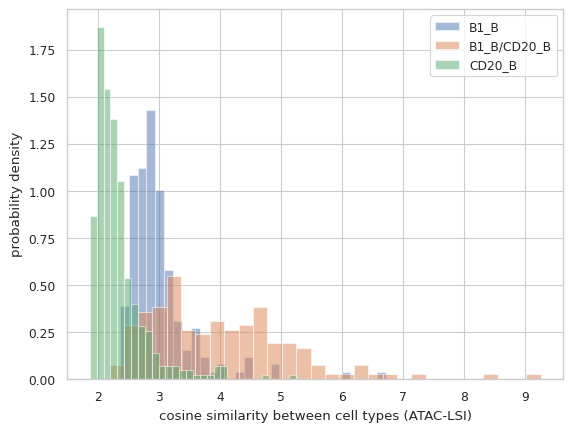

In [279]:
# Calculate euclidean distance using the LSIs used to generate the ATAC umap (ATAC)

# B1_B vs CD20+B
B1_B_ATAC = B1_B.obsm["X_lsi_red"]
CD20_B_ATAC = CD20_B.obsm["X_lsi_red"]
Trans_B_ATAC = Trans_B.obsm["X_lsi_red"]

B1_B_dist = euclidean_distances(B1_B_ATAC, B1_B_ATAC).mean(axis=1)
B1_B_CD20_B_dist = euclidean_distances(B1_B_ATAC, CD20_B_ATAC).mean(axis=1)
CD20_B_dist = euclidean_distances(CD20_B_ATAC, CD20_B_ATAC).mean(axis=1)

# Panel A
#bins = np.linspace(-0.2, 0.9, 30)
bins=30
# ax = axes[0,0]
plt.hist(B1_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_dist, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (ATAC-LSI)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_euclid_dist_Bcells_lsi.pdf")

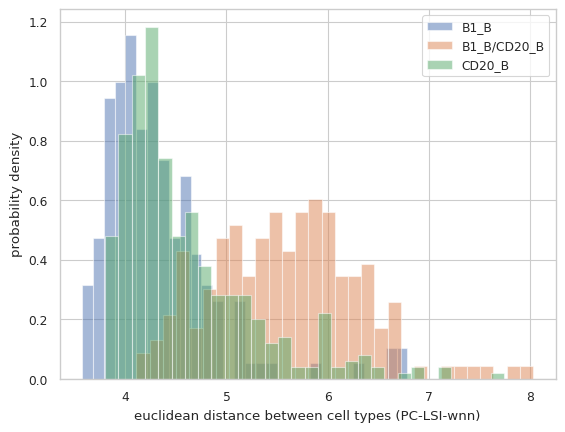

In [280]:
# Calculate euclidean distances using the weighted combination of PCs and LSIs used to generate the joint WNN umap (WNN)

# B1_B vs CD20+B
B1_B_wnn = B1_B.obsm["X_wnn_pca_lsi"]
CD20_B_wnn = CD20_B.obsm["X_wnn_pca_lsi"]
Trans_B_wnn = Trans_B.obsm["X_wnn_pca_lsi"]

B1_B_dist = euclidean_distances(B1_B_wnn, B1_B_wnn).mean(axis=1)
B1_B_CD20_B_dist = euclidean_distances(B1_B_wnn, CD20_B_wnn).mean(axis=1)
CD20_B_dist = euclidean_distances(CD20_B_wnn, CD20_B_wnn).mean(axis=1)

# Panel A
#bins = np.linspace(5, 12, 30)
bins=30
# ax = axes[0,0]
plt.hist(B1_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_dist, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_dist, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('euclidean distance between cell types (PC-LSI-wnn)')
plt.ylabel('probability density')
plt.legend(["B1_B", "B1_B/CD20_B","CD20_B"])
plt.savefig(figpath+"hist_euclid_dist_Bcells_pca+lsi.pdf")

## Similarity metrics between progenitor subtypes

Progenitor cells are the cells that were clustered together in RNA/ATAC UMAPs at the center of the UMAPs.
The subtypes are the following:

- G/M prog
- Lymph prog
- HSC
- MK/E prog
- pDC (which is mixed in RNA UMAP, but well-separated in ATAC UMAP)

Of course, there are other progenitor subtypes, but those are relatively well separated in the UMAP, so we will just focus on the above cell types.

In [228]:
adata.obs["cell_type"].unique().to_list()

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

In [229]:
# subset the B cell subtype populations
celltype1 = adata[adata.obs["cell_type"]=="Lymph prog"]
celltype2 = adata[adata.obs["cell_type"]=="MK/E prog"]
#celltype3 = adata[adata.obs["cell_type"]=="HSC"]


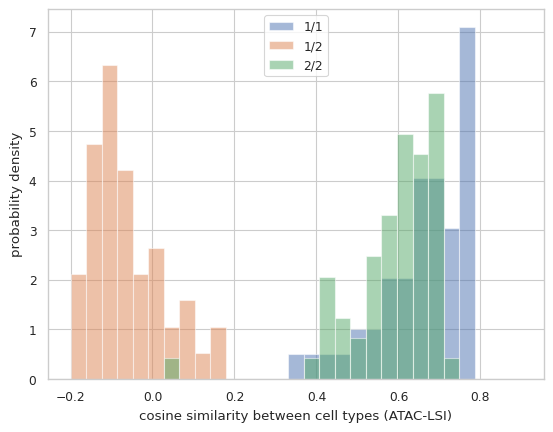

In [282]:
# Calculate cosine similarity using the LSIs used to generate the ATAC umap (ATAC)

# celltype1 vs celltype2
cell1_ATAC = celltype1.obsm["X_lsi_red"]
cell2_ATAC = celltype2.obsm["X_lsi_red"]

cell1_cos = cosine_similarity(cell1_ATAC, cell1_ATAC).mean(axis=1)
cell1_2_cos = cosine_similarity(cell1_ATAC, cell2_ATAC).mean(axis=1)
cell2_cos = cosine_similarity(cell2_ATAC, cell2_ATAC).mean(axis=1)

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
#bins=30
# ax = axes[0,0]
plt.hist(cell1_cos, alpha=0.5, bins=bins, density = True)
plt.hist(cell1_2_cos, alpha=0.5, bins=bins, density = True)
plt.hist(cell2_cos, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (ATAC-LSI)')
plt.ylabel('probability density')
plt.legend(["1/1", "1/2","2/2"])


In [283]:
# Calculate cosine similarity using both PCA and LSI (RNA and ATAC)

# celltype1 vs celltype2
cell1_wnn = celltype1.obsm["X_wnn_pca_lsi"]
cell2_wnn = celltype2.obsm["pca_lsi_WNN"]

cell1_cos = cosine_similarity(cell1_wnn, cell1_wnn).mean(axis=1)
cell1_2_cos = cosine_similarity(cell1_wnn, cell2_wnn).mean(axis=1)
cell2_cos = cosine_similarity(cell2_wnn, cell2_wnn).mean(axis=1)

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
#bins=30
# ax = axes[0,0]
plt.hist(cell1_cos, alpha=0.5, bins=bins, density = True)
plt.hist(cell1_2_cos, alpha=0.5, bins=bins, density = True)
plt.hist(cell2_cos, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
plt.xlabel('cosine similarity between cell types (PCA+LSI)')
plt.ylabel('probability density')
plt.legend(["1/1", "1/2","2/2"])



KeyError: 'pca_lsi_WNN'

In [108]:
 len(cosine_similarity(B1_B_wnn, B1_B_wnn))

178

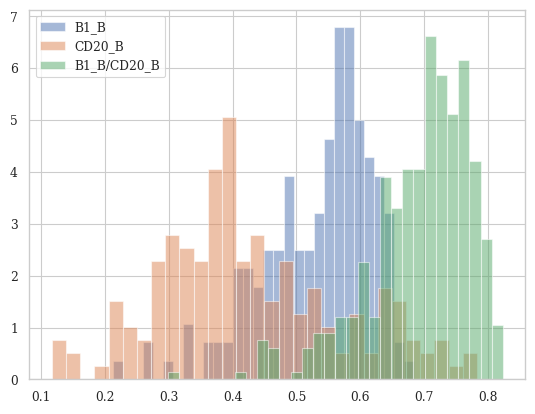

In [332]:
# Calculate cosine similarity using only the marker genes (RNA)

# subset for the marker genes only
# 'MS4A1' this is expressed highly for both B1 B and CD20+Naive B
# best marker set
# markers_RNA = ['IL4R', 'IGHD', 'FCRL1', 'IGHM', 
#                'SSPN', 'ITGB1', 'EPHA4', 'COL4A4']
markers_RNA = ['IL4R', 'IGHD', 'FCRL1', 'IGHM', 'MS4A1',
               'SSPN', 'ITGB1', 'EPHA4', 'COL4A4','PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK'] # - seem to be weak
               #'MME', 'CD38', 'CD24', 'ACSM3', 'MSI2']
markers_RNA = [x+"-RNA" for x in markers_RNA]

# B1_B vs CD20+B
B1_B_RNA = B1_B[:, markers_RNA]
CD20_B_RNA = CD20_B[:, markers_RNA]
Trans_B_RNA = Trans_B[:, markers_RNA]

# We are adding blank columns to make coloring in the plots more easily automated
# sim_B1B = pd.DataFrame(index=B1_B.obs.index,
#                        columns=['B1 B', 'B1 B - CD20+ Naive B', 'CD20+ Naive B'])

# sim_B1B['B1 B'] = cosine_similarity(B1_B_RNA.X, B1_B_RNA.X).mean(axis=1)
# sim_B1B['B1 B - CD20+ Naive B'] = cosine_similarity(B1_B_RNA.X, CD20_B_RNA.X).mean(axis=1)
# sim_B1B['CD20+ Naive B'] = cosine_similarity(CD20_B_RNA.X, CD20_B_RNA.X).mean(axis=1)

B1_B_cosine = cosine_similarity(B1_B_RNA.X, B1_B_RNA.X).mean(axis=1)
B1_B_CD20_B_cosine = cosine_similarity(B1_B_RNA.X, CD20_B_RNA.X).mean(axis=1)
CD20_B_cosine = cosine_similarity(CD20_B_RNA.X, CD20_B_RNA.X).mean(axis=1)

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
bins=30
# ax = axes[0,0]
plt.hist(B1_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(B1_B_CD20_B_cosine, alpha=0.5, bins=bins, density = True)
plt.hist(CD20_B_cosine, alpha=0.5, bins=bins, density = True)

# ax.set_ylim(0, 14)
ax.set_xlabel('cosine similarity between cell types (RNA)')
ax.set_ylabel('probability density')
plt.legend({"B1_B", "B1_B/CD20_B","CD20_B"})

# Computing the fraction of cell types within the nearest-neighbors

Description: 

In [287]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v7.h5ad")

In [288]:
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05'
    var: 'assay'
    uns: 'ATAC', 'ATAC_leiden_05_colors', 'GEX_leiden_05_colors', 'RNA', 'cell_type_colors', 'leiden'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA'
    obsp: 'ATAC_connectivities', 'ATAC_distances', 'RNA_connectivities', 'RNA_distances', 'WNN_connectivities', 'connectivities', 'distances'

In [289]:
adata.obsp

PairwiseArrays with keys: ATAC_connectivities, ATAC_distances, RNA_connectivities, RNA_distances, WNN_connectivities, connectivities, distances

In [290]:
adata.obsp["connectivities"].todense()[0]

matrix([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [291]:
# subset the B cell subtype populations
B1_B = adata[adata.obs["manual_annotation_B_fine"]=="B1 B"]
CD20_B = adata[adata.obs["manual_annotation_B_fine"]=="Naive CD20+ B"]
Trans_B = adata[adata.obs["manual_annotation_B_fine"]=="Transitional B"]

# Use the neurips annotation
# B1_B = adata[adata.obs["cell_type"]=="B1 B"]
# CD20_B = adata[adata.obs["cell_type"]=="Naive CD20+ B"]
# Trans_B = adata[adata.obs["cell_type"]=="Transitional B"]

In [317]:
# function to compute the fraction of cell types for the neighbors within a group of cells
# output: a list of fractions for each cell (each cell from "cell_type_query" type)
def compute_frac_celltypes_from_neighbors(adata, annotation_label, 
                                          cell_type_query, cell_type_fraction, neighbor_key):
    # input arguments:
    # adata: anndata object
    # annotation_label: adata.obs["annotation_label"], the level of annotation we will use
    # cell_type_query: cell type that we're curious about their nearest-neighbors
    # cell_type_fraction: cell type that we're curious about how much they take up within the "cell_type_query"'s nearest-neighbors
    # neighbor_key: the neighborhood key, which we need to specify which modality it was calculated from
    
    
    # subset the dataset for the given cell_type by getting indices
    cell_indices = np.where(adata.obs[annotation_label] == cell_type_query)[0]

    # loop through each cell and calculate the fraction of neighboring cells
    # that are of the same cell type
    neighborhood_fractions = []
    for idx in cell_indices:
        # get the indices of the neighbors of the current cell
        #neighbor_key = "connectivities"
        neighbor_indices = adata.obsp[neighbor_key][idx].nonzero()[1]
        # get the cell types of the neighbors
        neighbor_cell_types = adata.obs[annotation_label][neighbor_indices]
        # calculate the fraction of neighbors that are of the same cell type
        fraction = np.mean(neighbor_cell_types == cell_type_fraction)
        neighborhood_fractions.append(fraction)
        
    return neighborhood_fractions
    
    

In [179]:
adata.obsp["ATAC_connectivities"]

<6224x6224 sparse matrix of type '<class 'numpy.float32'>'
	with 144894 stored elements in Compressed Sparse Row format>

In [293]:
frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="RNA_connectivities")

frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="ATAC_connectivities")

frac_WNN = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="WNN_connectivities")

Text(0.5, 1.0, 'Transitional B')

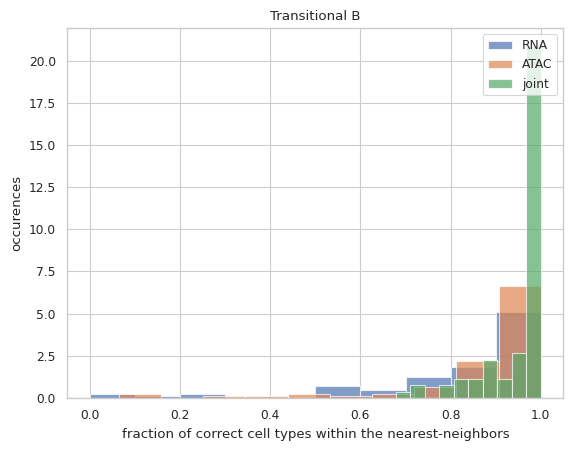

In [298]:
plt.hist(frac_RNA, bins=10, alpha=0.7, density=True)
plt.hist(frac_ATAC, bins=10, alpha=0.7, density=True)
plt.hist(frac_WNN, bins=10, alpha=0.7, density=True)
plt.legend({"RNA","ATAC","joint"}, loc=1)
#plt.ylim([0, 80])
plt.xlabel("fraction of correct cell types within the nearest-neighbors")
plt.ylabel("occurences")
plt.title("Transitional B")


In [301]:
frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="RNA_connectivities")

frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="ATAC_connectivities")

frac_WNN = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="WNN_connectivities")

Text(0.5, 1.0, 'B1 B')

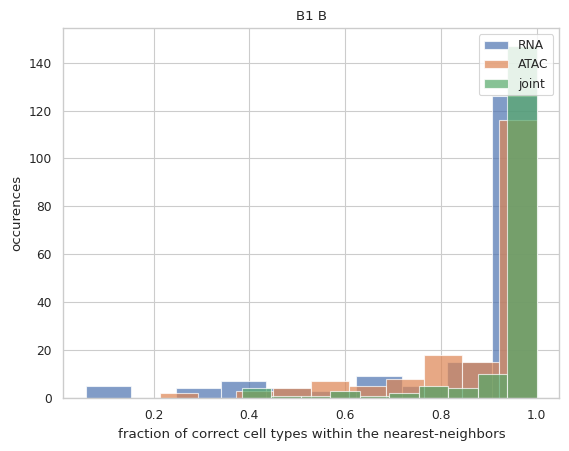

In [303]:
plt.hist(frac_RNA, bins=10, alpha=0.7)
plt.hist(frac_ATAC, bins=10, alpha=0.7)
plt.hist(frac_WNN, bins=10, alpha=0.7)
plt.legend({"RNA","ATAC","joint"}, loc=1)
# plt.ylim([0, 80])
plt.xlabel("fraction of correct cell types within the nearest-neighbors")
plt.ylabel("occurences")
plt.title("B1 B")


## conclusion

- 1) The fraction of correct cell-types within the nearest-neighbors is cleaner (higher) in "joint(RNA+ATAC)" than each individual modality (RNA or ATAC).

Now, let's generate a more comprehensive plots for this:

- bar plot showing each cell as a thin vertical line where the y-axis is the fraction of cell types in the nearest neighbors.
- Sort the bars from high to low (purer cells to less purer cells)



In [353]:
# function to compute the fraction of cell types for the neighbors within a group of cells
# output: a list of fractions for each cell (each cell from "cell_type_query" type)
def compute_frac_celltypes_from_neighbors(adata, annotation_label, 
                                          cell_type_interest, cell_types_fraction, neighbor_key):
    # input arguments:
    # adata: anndata object
    # annotation_label: adata.obs["annotation_label"], the level of annotation we will use
    # cell_type_query: cell type that we're curious about their nearest-neighbors
    # cell_type_fraction: cell type that we're curious about how much they take up within the "cell_type_query"'s nearest-neighbors
    # neighbor_key: the neighborhood key, which we need to specify which modality it was calculated from
    
    
    # subset the dataset for the given cell_type by getting indices
    cell_indices = np.where(adata.obs[annotation_label] == cell_type_interest)[0]
    
    # create an empty dataframe (cell_ids by cell_types)
    df_fractions = pd.DataFrame(index=adata.obs_names[cell_indices],
                                columns=cell_types_fraction)

    # loop through each cell and calculate the fraction of neighboring cells
    # that are of the same cell type
    neighborhood_fractions = np.zeros((len(cell_indices), len(cell_types)), dtype=np.float64)
    for idx in cell_indices:
        cell_id = adata.obs_names[idx]
        # get the indices of the neighbors of the current cell
        #neighbor_key = "connectivities"
        neighbor_indices = adata.obsp[neighbor_key][idx].nonzero()[1]
        # get the cell types of the neighbors
        neighbor_cell_types = adata.obs[annotation_label][neighbor_indices]
        # calculate the fraction of neighbors that are of the same cell type
        # 1 x num_cell_types numpy array (initialize)
        fractions=[] 
        for cell_type in cell_types_fraction:
            fraction = np.mean(neighbor_cell_types == cell_type)
            fractions.append(fraction)
            # neighborhood_fractions.append(fraction)
            
        df_fractions.loc[cell_id,:] = fractions
        
    return df_fractions

In [339]:
# neighbor_indices = adata.obsp["RNA_connectivities"][7].nonzero()[1]
# neighbor_indices

# neighbor_cell_types = adata.obs["manual_annotation_B_fine"][neighbor_indices]
# neighbor_cell_types

AAACGTACACAGAACG-1             B1 B
ACCAGCTCATACTCCT-1    Naive CD20+ B
ACCTCACTCGCTAGTG-1             B1 B
ACCTTGTGTGGAAACG-1             B1 B
AGGCTAAAGCACAGAA-1             B1 B
ATCACCCTCACGCCAA-1    Naive CD20+ B
CAACAGGCACAGAAAC-1             B1 B
CCGTTACTCTTGTCCA-1             B1 B
CGCATTTGTGGTTATG-1             B1 B
CTTCAGGAGTCTTGAA-1             B1 B
CTTTAGTTCTAAGTGC-1             B1 B
GATAAAGGTCACACCC-1             B1 B
GGATACTTCATGGTGT-1             B1 B
GGCTGAGAGTTATGTG-1    Naive CD20+ B
GTCTAGCCAACCCTCC-1             B1 B
GTTCTTGTCTATGACA-1       unassigned
GTTGCATAGACAGGCG-1             B1 B
TAGGGTTTCGAGGAAC-1             B1 B
TATAGCCAGCACCACA-1             B1 B
Name: manual_annotation_B_fine, dtype: category
Categories (4, object): ['B1 B', 'Naive CD20+ B', 'Transitional B', 'unassigned']

In [355]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "B1 B"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["B1 B", "Naive CD20+ B","Transitional B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

In [370]:
# Sort DataFrame by values in cell_type1 column
# df_sorted = df_frac_RNA.iloc[df_frac_RNA['B1 B'].argsort()]
df_sorted = df_frac_RNA.sort_values('B1 B', ascending=False)
df_sorted

,B1 B,Naive CD20+ B,Transitional B,unassigned
CTGTTAAAGATGCCTG-1,1.0,0.0,0.0,0.0
GCTAAGAAGCACGATT-1,1.0,0.0,0.0,0.0
GCGATTAGTCCTTCTC-1,1.0,0.0,0.0,0.0
GCCCATAAGTCCTTCA-1,1.0,0.0,0.0,0.0
GCCCAAATCATGAGCT-1,1.0,0.0,0.0,0.0
...,...,...,...,...
CGCATTTGTGGTTATG-1,0.142857,0.857143,0.0,0.0
GTCGAGGAGGTGCGGA-1,0.125,0.875,0.0,0.0
AGCTACGTCCTTAGTT-1,0.117647,0.882353,0.0,0.0
CGAAGCGAGGAGGTTA-1,0.105263,0.894737,0.0,0.0


In [368]:
df_frac_RNA_sorted = df_frac_RNA.sort_index(axis=0, level="B1 B", ascending=True)
df_frac_RNA_sorted

,B1 B,Naive CD20+ B,Transitional B,unassigned
AAACATGCAGTATGTT-1,0.789474,0.157895,0.0,0.052632
AAACGTACACAGAACG-1,0.666667,0.333333,0.0,0.0
AACGACAAGCACCACA-1,1.0,0.0,0.0,0.0
AACGACAAGTTGTCAA-1,0.733333,0.266667,0.0,0.0
AAGCGAATCCCATAGG-1,1.0,0.0,0.0,0.0
...,...,...,...,...
TTGCAATCAAACGGGC-1,0.956522,0.043478,0.0,0.0
TTGGCTACACTGGCTG-1,1.0,0.0,0.0,0.0
TTGTGCGAGCAGCTCA-1,1.0,0.0,0.0,0.0
TTGTTCCCAGCACCAT-1,1.0,0.0,0.0,0.0


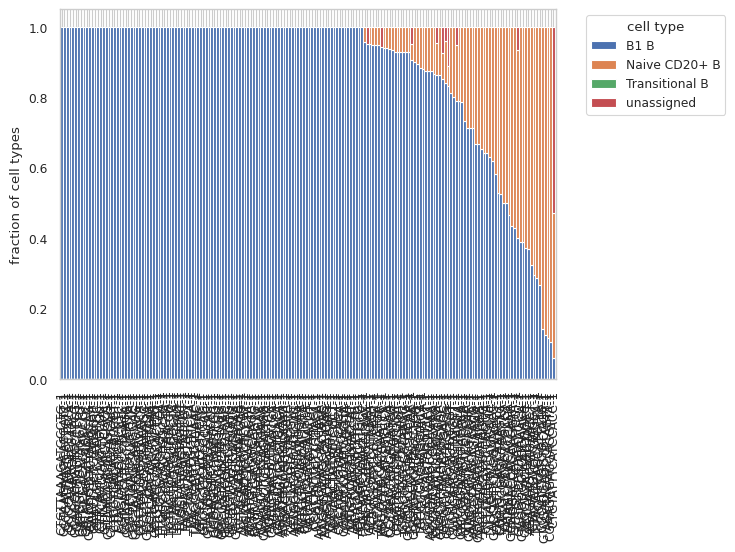

In [372]:
df_sorted = df_frac_RNA.sort_values('B1 B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

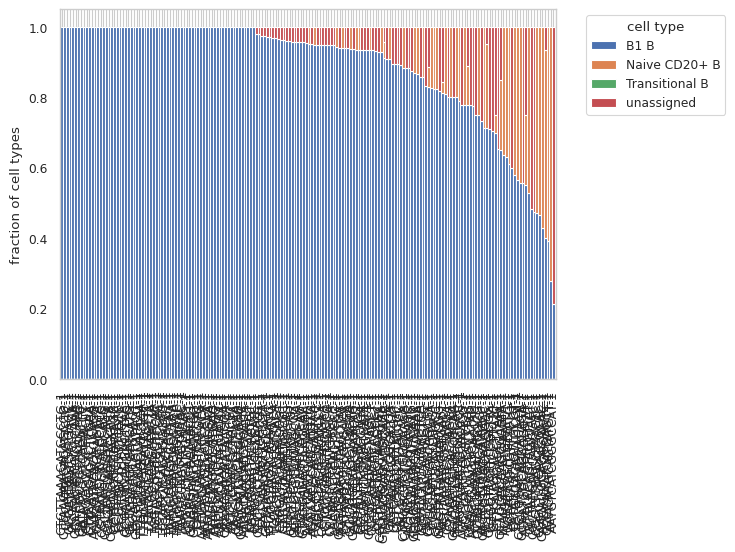

In [379]:
df_sorted = df_frac_ATAC.sort_values('B1 B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

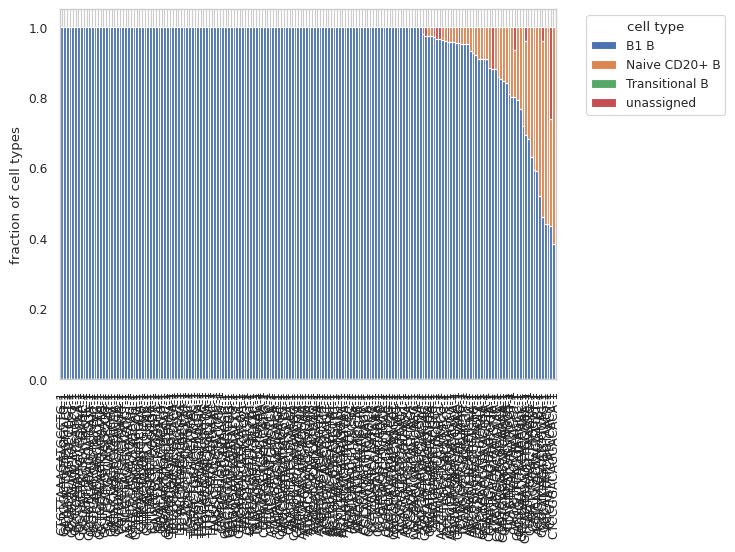

In [380]:
df_sorted = df_frac_joint.sort_values('B1 B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

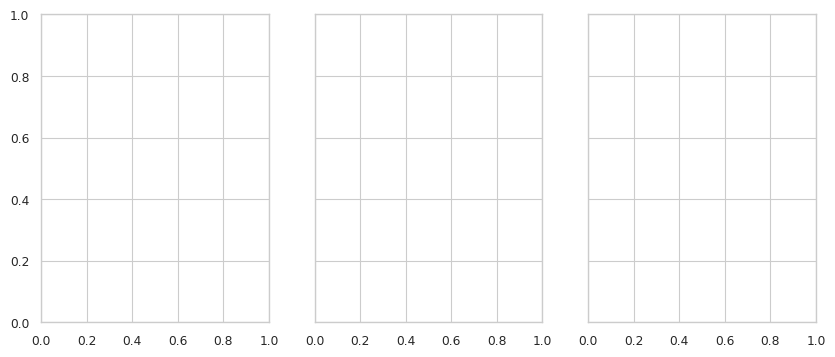

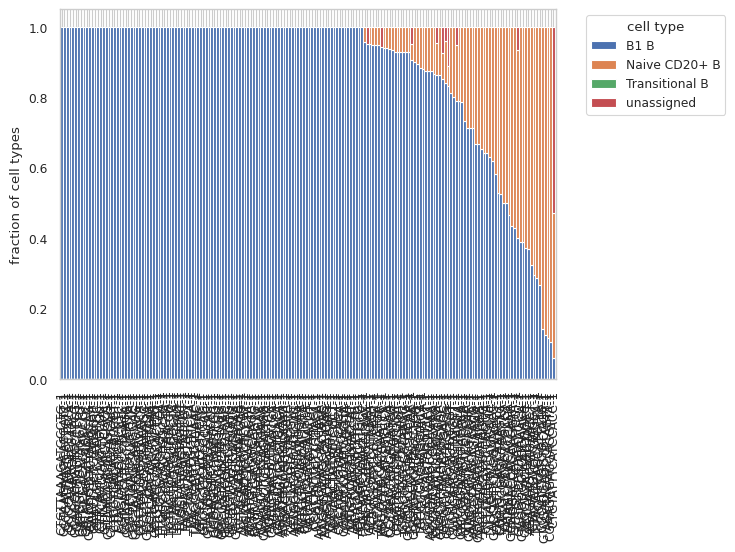

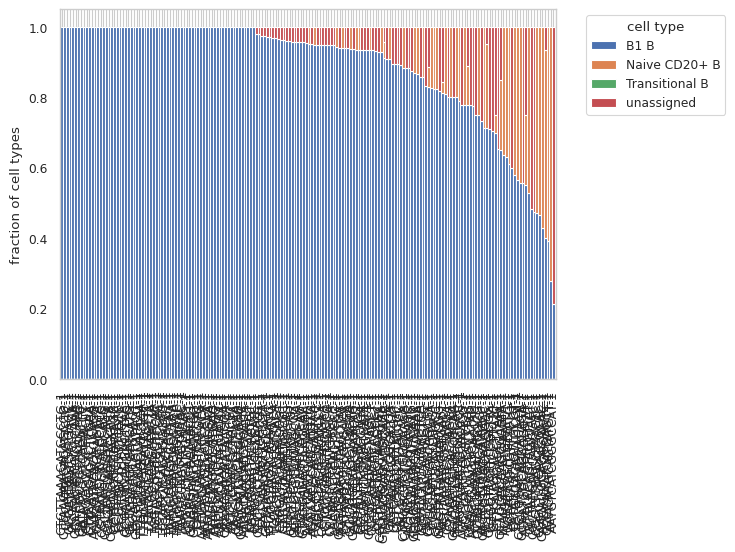

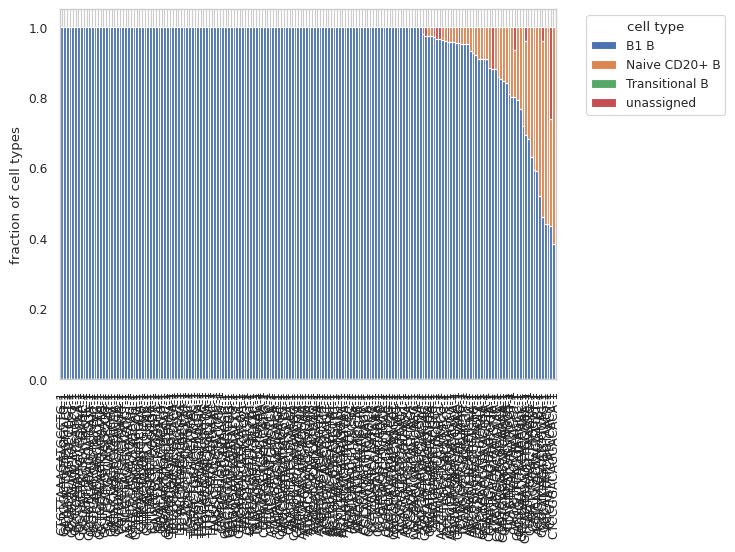

In [386]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True)



df_sorted_RNA = df_frac_RNA.sort_values('B1 B', ascending=False)
axs[0] = df_sorted_RNA.plot(kind="bar", stacked=True, width=1)
axs[0].set_ylabel("fraction of cell types")
axs[0].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

df_sorted_ATAC = df_frac_ATAC.sort_values('B1 B', ascending=False)
axs[1] = df_sorted_ATAC.plot(kind="bar", stacked=True, width=1)
axs[1].set_ylabel("fraction of cell types")
axs[1].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

df_sorted_joint = df_frac_joint.sort_values('B1 B', ascending=False)
axs[2] = df_sorted_joint.plot(kind="bar", stacked=True, width=1)
axs[2].set_ylabel("fraction of cell types")
axs[2].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.show()

In [385]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharey=True)

# df_sorted_RNA = df_frac_RNA.sort_values('B1 B', ascending=False)
# axs[0].bar(df_sorted_RNA.index, df_sorted_RNA['B1 B'], width=0.8, label='B1 B')
# axs[0].bar(df_sorted_RNA.index, df_sorted_RNA['B2 B'], bottom=df_sorted_RNA['B1 B'], width=0.8, label='B2 B')
# axs[0].bar(df_sorted_RNA.index, df_sorted_RNA['B3 B'], bottom=df_sorted_RNA[['B1 B', 'B2 B']].sum(axis=1), width=0.8, label='B3 B')
# axs[0].bar(df_sorted_RNA.index, df_sorted_RNA['B4 B'], bottom=df_sorted_RNA[['B1 B', 'B2 B', 'B3 B']].sum(axis=1), width=0.8, label='B4 B')
# axs[0].set_title('RNA')
# axs[0].set_xlabel('Cell ID')
# axs[0].set_ylabel('Fraction of Cell Types')
# axs[0].legend(title="Cell Type", bbox_to_anchor=(1.05,1), loc="upper left")

# df_sorted_ATAC = df_frac_ATAC.sort_values('B1 B', ascending=False)
# axs[1].bar(df_sorted_ATAC.index, df_sorted_ATAC['B1 B'], width=0.8, label='B1 B')
# axs[1].bar(df_sorted_ATAC.index, df_sorted_ATAC['B2 B'], bottom=df_sorted_ATAC['B1 B'], width=0.8, label='B2 B')
# axs[1].bar(df_sorted_ATAC.index, df_sorted_ATAC['B3 B'], bottom=df_sorted_ATAC[['B1 B', 'B2 B']].sum(axis=1), width=0.8, label='B3 B')
# axs[1].bar(df_sorted_ATAC.index, df_sorted_ATAC['B4 B'], bottom=df_sorted_ATAC[['B1 B', 'B2 B', 'B3 B']].sum(axis=1), width=0.8, label='B4 B')
# axs[1].set_title('ATAC')
# axs[1].set_xlabel('Cell ID')
# axs[1].set_ylabel('Fraction of Cell Types')
# axs[1].legend(title="Cell Type", bbox_to_anchor=(1.05,1), loc="upper left")

# df_sorted_joint = df_frac_joint.sort_values('B1 B', ascending=False)
# axs[2].bar(df_sorted_joint.index, df_sorted_joint['B1 B'], width=0.8, label='B1 B')
# axs[2].bar(df_sorted_joint.index, df_sorted_joint['B2 B'], bottom=df_sorted_joint['B1 B'], width=0.8, label='B2 B')
# axs[2].bar(df_sorted_joint.index, df_sorted_joint['B3 B'], bottom=df_sorted_joint[['B1 B', 'B2 B']].sum(axis=1), width=0.8, label='B3 B')
# axs[2].bar(df_sorted_joint.index, df_sorted_joint['B4 B'], bottom=df_sorted_joint[['B1 B', 'B2 B', 'B3 B']].sum(axis=1), width=0.8)


## transitional B cells

In [500]:
adata.uns["manual_annotation_B_fine_colors"] = adata.uns["cell_type_neurips_B_cells_colors"]

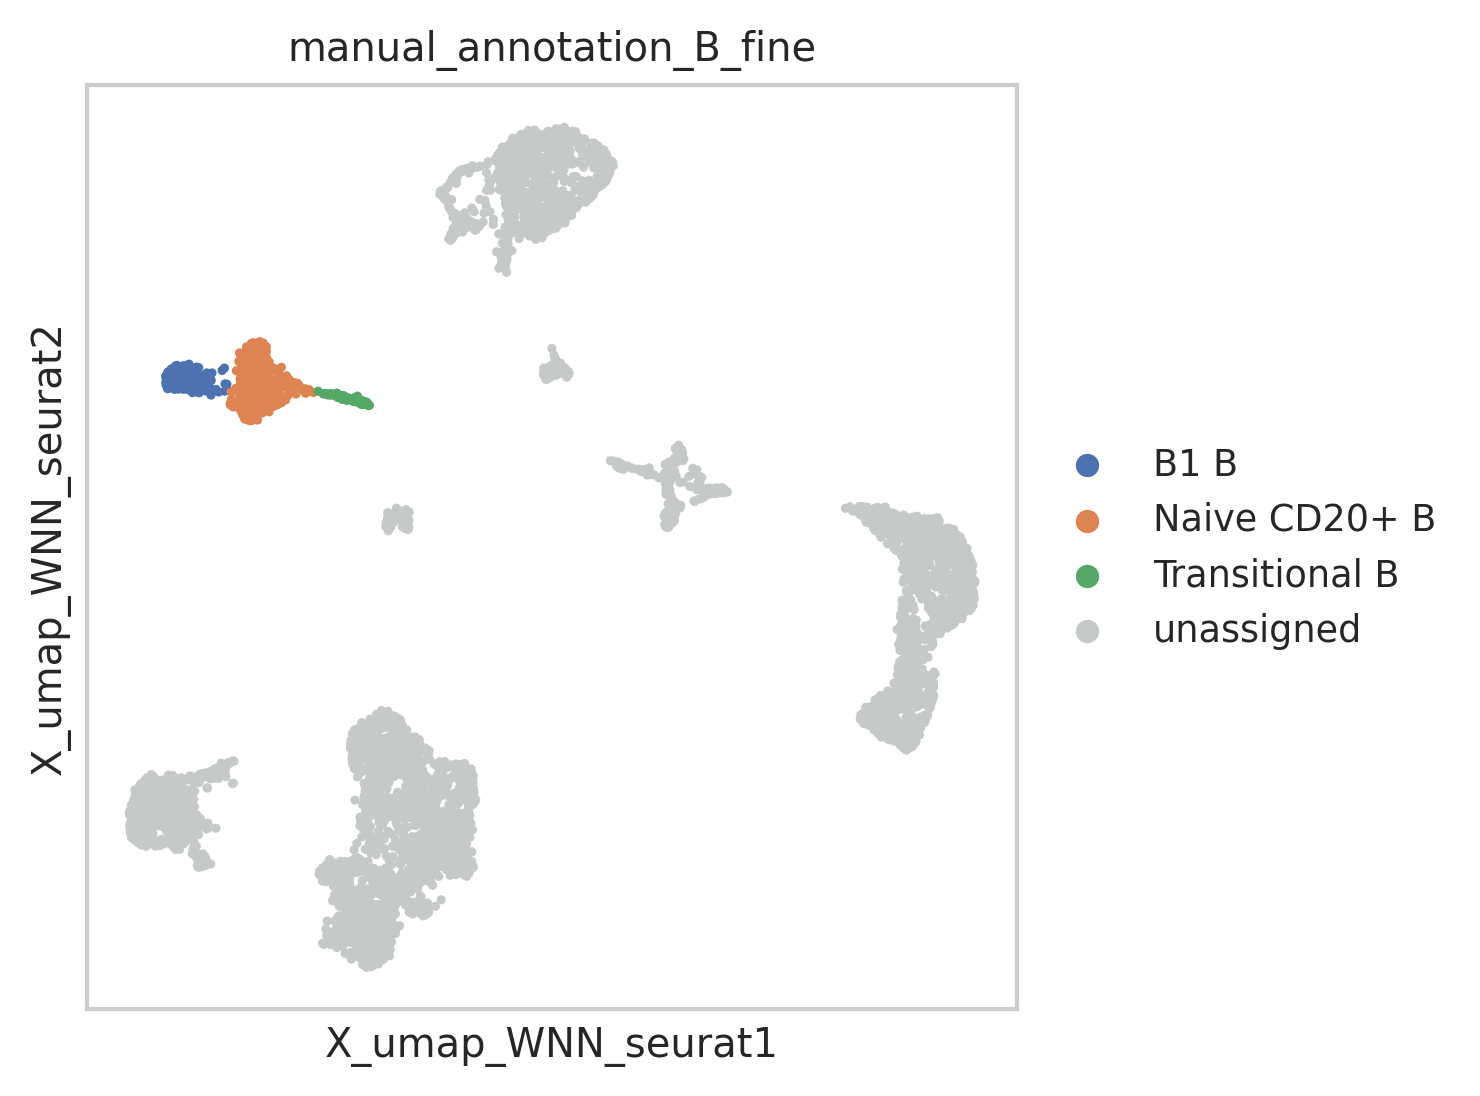

In [508]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_WNN_seurat", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

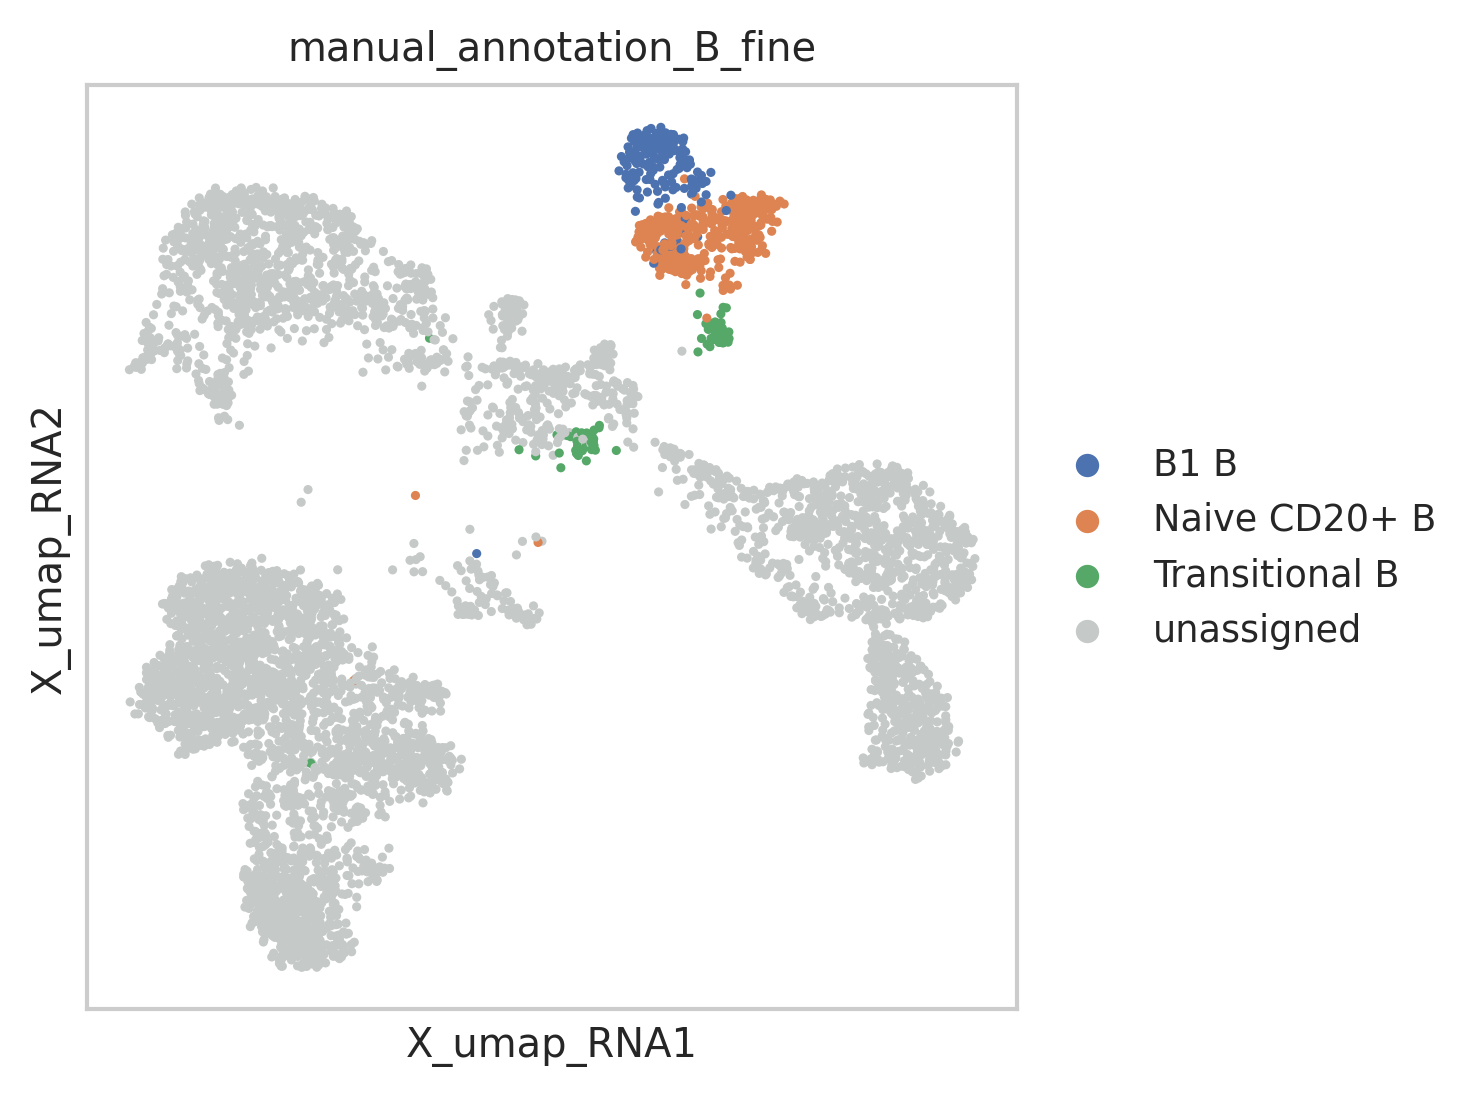

In [509]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_RNA", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

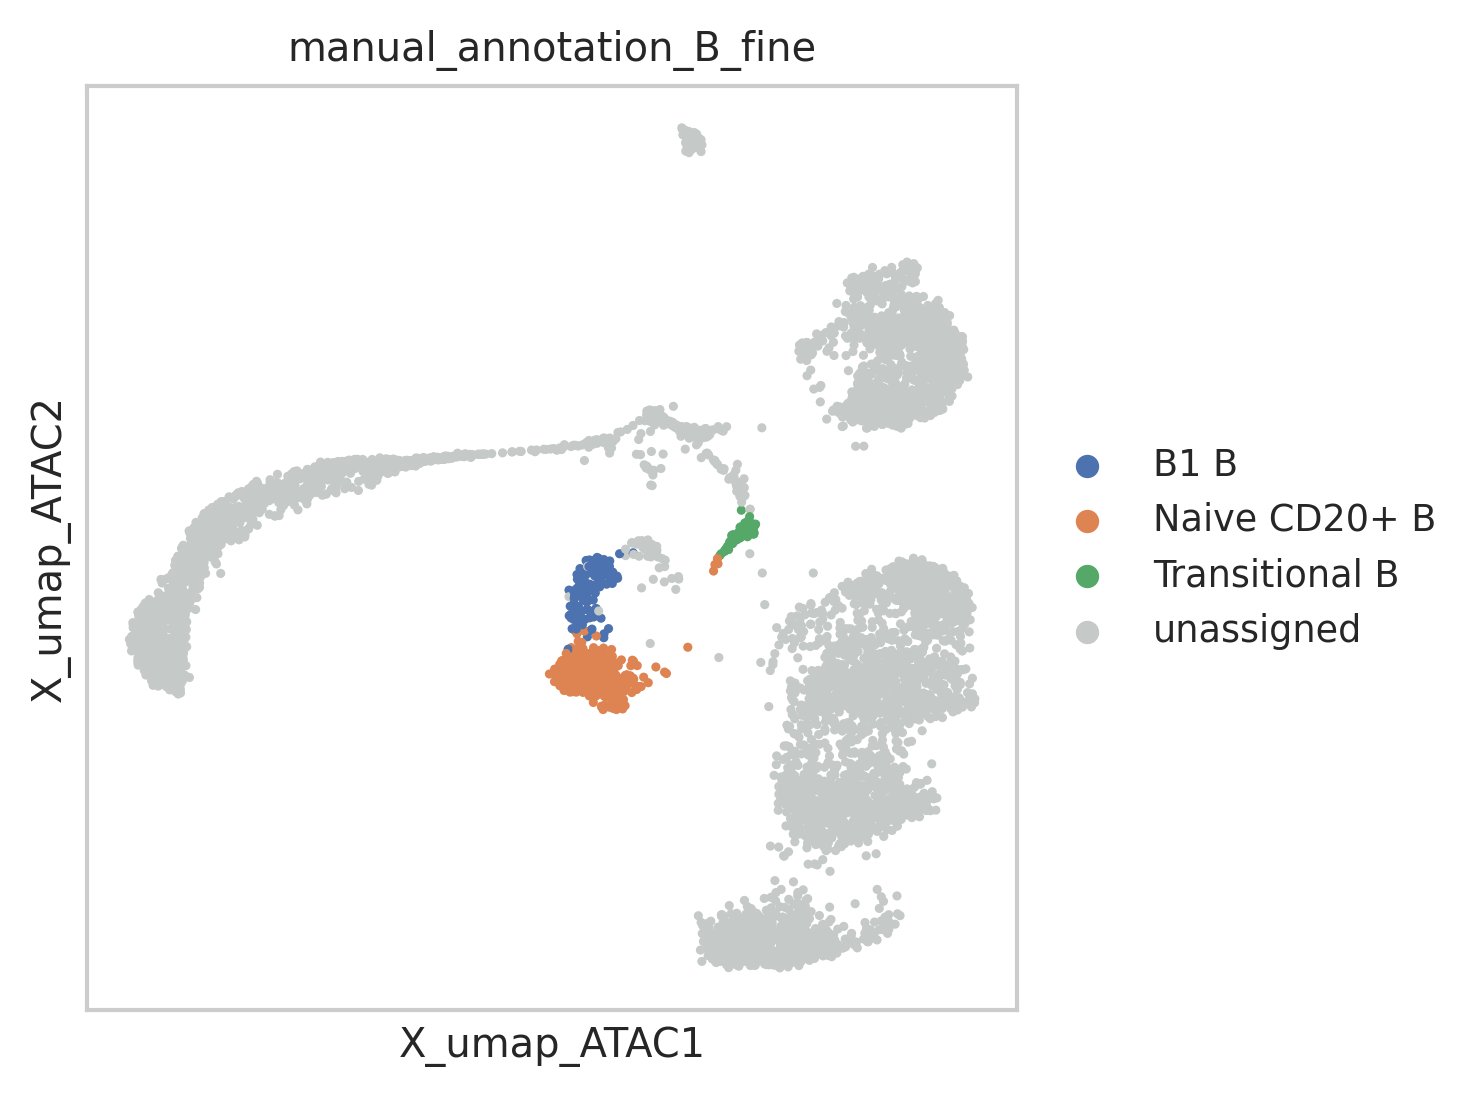

In [510]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_ATAC", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

In [488]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "Transitional B"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["B1 B", "Naive CD20+ B","Transitional B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

In [398]:
list_cols_order = ["Transitional B", "B1 B", "Naive CD20+ B", "unassigned"]
df_frac_RNA = df_frac_RNA.reindex(columns= list_cols_order)
df_frac_RNA

df_frac_ATAC = df_frac_ATAC.reindex(columns=list_cols_order)
df_frac_joint = df_frac_joint.reindex(columns=list_cols_order)

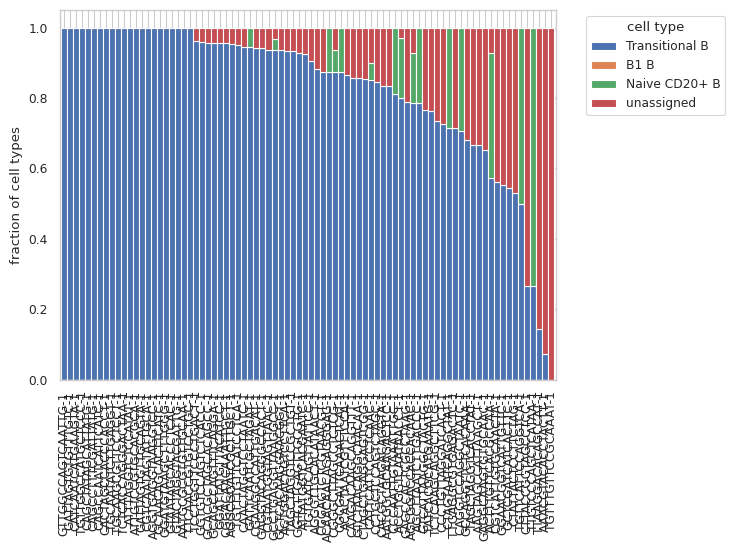

In [399]:
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

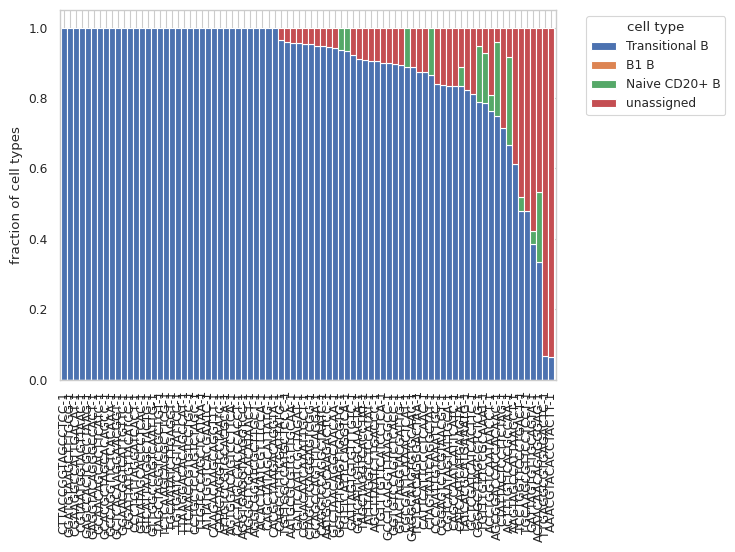

In [400]:
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

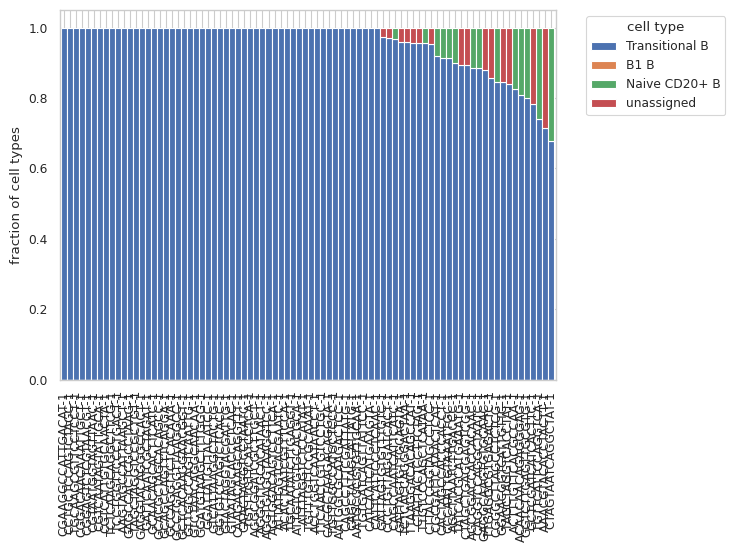

In [401]:
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

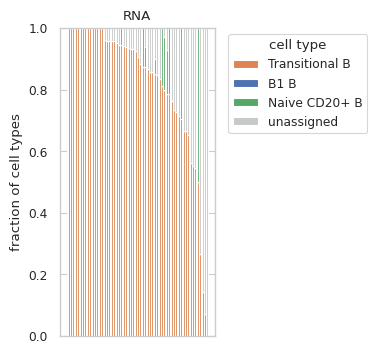

In [519]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
bar_width = 1
ax.bar(df_sorted.index,transB, color="#dd8452", width=bar_width,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=bar_width, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=bar_width, 
       label="Naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=bar_width, label="unassigned")
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("RNA")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
with plt.rc_context({"figure.dpi": (300)}):
    plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_RNA_stacked_bars.pdf",
                dpi=300, bbox_inches="tig)
    plt.show()

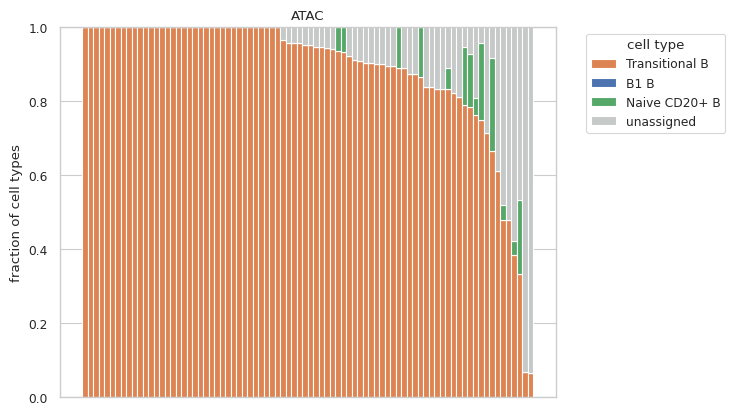

In [494]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots()
ax.bar(df_sorted.index,transB, color="#dd8452", width=1,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=1, 
       label="Naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned")
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("ATAC")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_ATAC_stacked_bars.pdf")
plt.show()

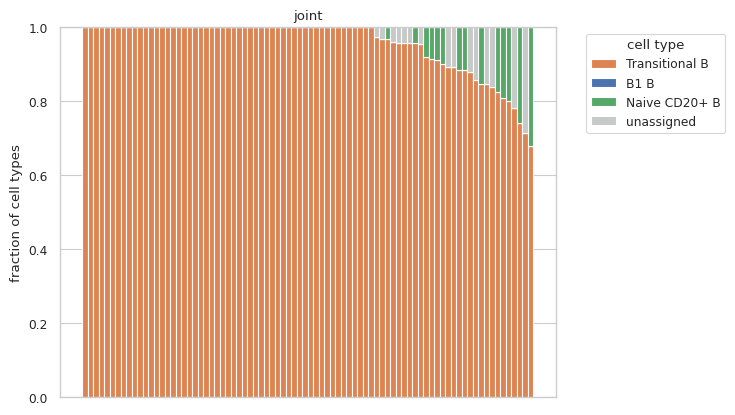

In [493]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots()
ax.bar(df_sorted.index,transB, color="#dd8452", width=1,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=1, 
       label="Naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned")
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("joint")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_joint_stacked_bars.pdf")
plt.show()

## Using the neurips 2021 annotation (as the ground truth)



In [404]:
adata.obs.cell_type.unique().to_list()

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

In [405]:
cell_type_dict = {'CD4+ T naive': 'unassigned',
                  'Lymph prog': 'unassigned',
                  'CD4+ T activated': 'unassigned',
                  'Erythroblast': 'unassigned',
                  'CD8+ T': 'unassigned',
                  'naive CD20+ B': 'naive CD20+ B',
                  'CD14+ Mono': 'unassigned',
                  'HSC': 'unassigned',
                  'NK': 'unassigned',
                  'pDC': 'unassigned',
                  'B1 B': 'B1 B',
                  'G/M prog': 'unassigned',
                  'Normoblast': 'unassigned',
                  'CD16+ Mono': 'unassigned',
                  'MK/E prog': 'unassigned',
                  'ILC': 'unassigned',
                  'ID2-hi myeloid prog': 'unassigned',
                  'Proerythroblast': 'unassigned',
                  'cDC2': 'unassigned',
                  'Transitional B': 'Transitional B',
                  'Plasma cells': 'unassigned'}

In [408]:
# generate an annotation label where only the B cell subtypes were labelled

adata.obs["cell_type_neurips_B_cells"] = adata.obs["cell_type"].map(cell_type_dict)
adata.obs["cell_type_neurips_B_cells"]

AAACAGCCAATTAAGG-1    unassigned
AAACAGCCAGGCTGTT-1    unassigned
AAACATGCAAAGCGCA-1    unassigned
AAACATGCAATAACCT-1    unassigned
AAACATGCAATAATGG-1    unassigned
                         ...    
TTTGTGTTCATGTGGT-1    unassigned
TTTGTGTTCATTTGCT-1    unassigned
TTTGTGTTCGCCTAAG-1    unassigned
TTTGTTGGTACGGTAC-1    unassigned
TTTGTTGGTTCGGTAA-1    unassigned
Name: cell_type_neurips_B_cells, Length: 6224, dtype: object

In [463]:
adata.obs.cell_type_neurips_B_cells.unique()

['unassigned', 'naive CD20+ B', 'B1 B', 'Transitional B']
Categories (4, object): ['B1 B', 'Transitional B', 'naive CD20+ B', 'unassigned']

In [411]:
adata.obsm["X_umap_WNN_seurat"] = adata_test.obsm["X_umap_WNN_seurat"]

In [419]:
adata.uns["cell_type_neurips_B_cells_colors"] = ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7']

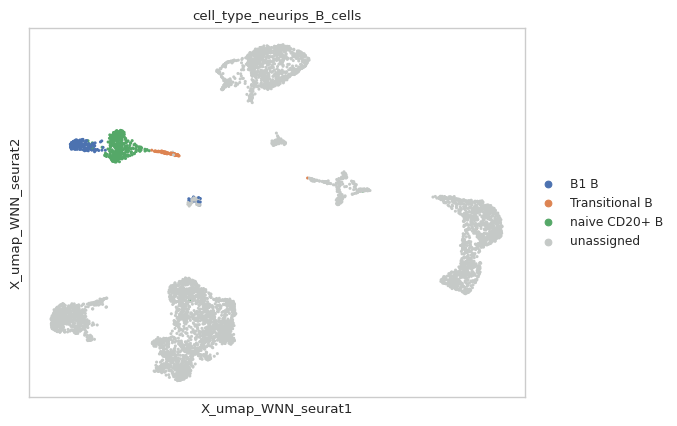

In [421]:
sc.pl.embedding(adata,basis="X_umap_WNN_seurat",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

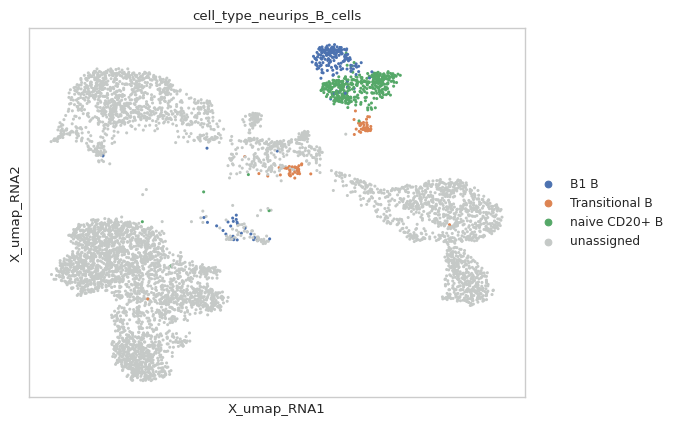

In [422]:
sc.pl.embedding(adata,basis="X_umap_RNA",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

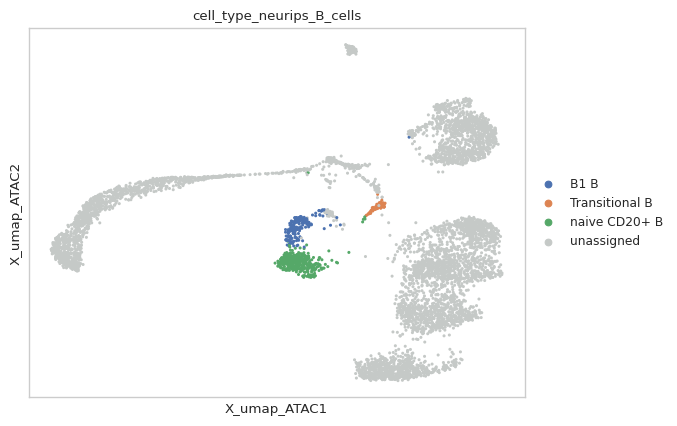

In [423]:
sc.pl.embedding(adata,basis="X_umap_ATAC",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

In [464]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "Transitional B"
# annotation label
annotation_class = "cell_type_neurips_B_cells"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["Transitional B", "B1 B", "naive CD20+ B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

In [425]:
# list_cols_order = ["Transitional B", "B1 B", "Naive CD20+ B", "unassigned"]
# df_frac_RNA = df_frac_RNA.reindex(columns= list_cols_order)
# df_frac_RNA

# df_frac_ATAC = df_frac_ATAC.reindex(columns=list_cols_order)
# df_frac_joint = df_frac_joint.reindex(columns=list_cols_order)

In [428]:
df_sorted

,Transitional B,B1 B,Naive CD20+ B,unassigned
CGTCAATAGTATTGCA-1,1.0,0.0,0.0,0.0
CACTAGCCACCCACCT-1,1.0,0.0,0.0,0.0
GCAACAGCACTTCATC-1,1.0,0.0,0.0,0.0
CAGCCTTTCGATTATG-1,1.0,0.0,0.0,0.0
CAGCTATAGCATTATG-1,1.0,0.0,0.0,0.0
...,...,...,...,...
TTGTCCCAGCTCATAA-1,0.266667,0.0,0.0,0.0
TTAAGGACACAGCCAT-1,0.142857,0.0,0.0,0.857143
CACAAGCGTCGTTATC-1,0.133333,0.066667,0.0,0.8
AGCATTTCACGTAATT-1,0.0,0.0,0.0,1.0


In [442]:
len(df_sorted.loc[:,"Transitional B"].to_list())

83

In [468]:
df_sorted

,Transitional B,B1 B,naive CD20+ B,unassigned
AAGTAGCCATTAAGCT-1,1.0,0.0,0.0,0.0
CAGCCTTTCGATTATG-1,1.0,0.0,0.0,0.0
CATCAATCATGAAGTA-1,1.0,0.0,0.0,0.0
CATTCATTCCCTCAAC-1,1.0,0.0,0.0,0.0
GTCTAACAGGCAACAA-1,1.0,0.0,0.0,0.0
...,...,...,...,...
TGTTCATTCCAGGTCA-1,0.740741,0.0,0.259259,0.0
CTAGTAATCAGGCTAT-1,0.678571,0.0,0.321429,0.0
CACAAGCGTCGTTATC-1,0.428571,0.0,0.0,0.571429
AGCATTTCACGTAATT-1,0.047619,0.0,0.0,0.952381


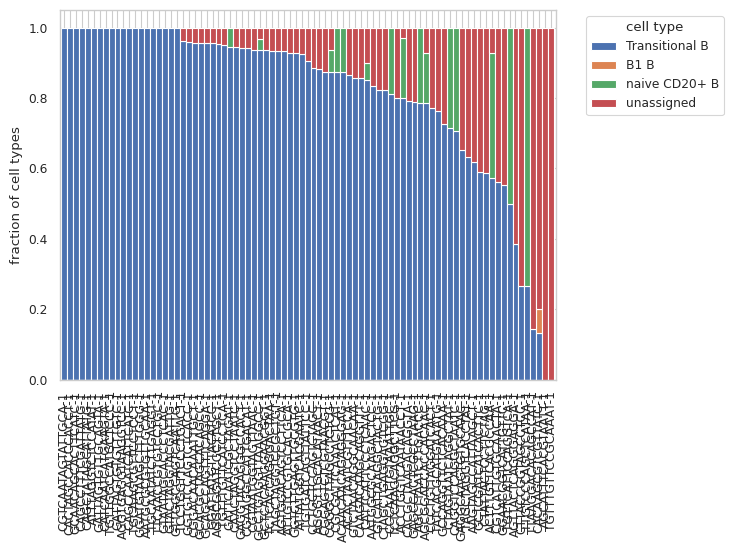

In [465]:
# RNA
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

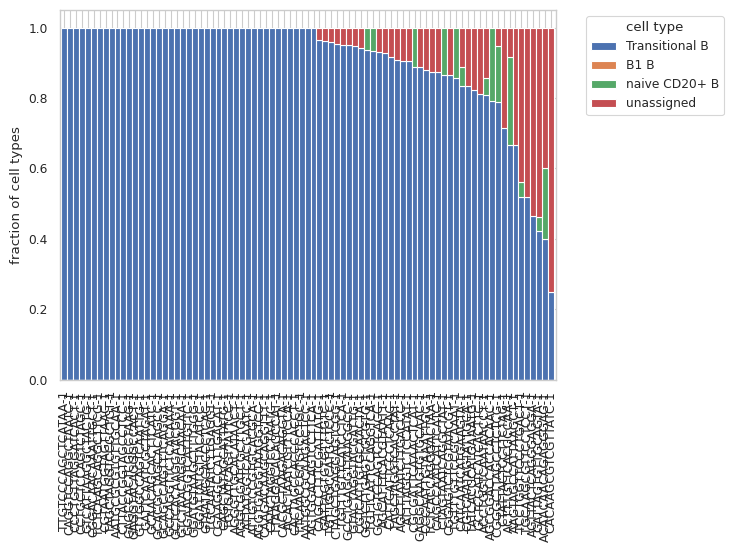

In [466]:
# ATAC
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

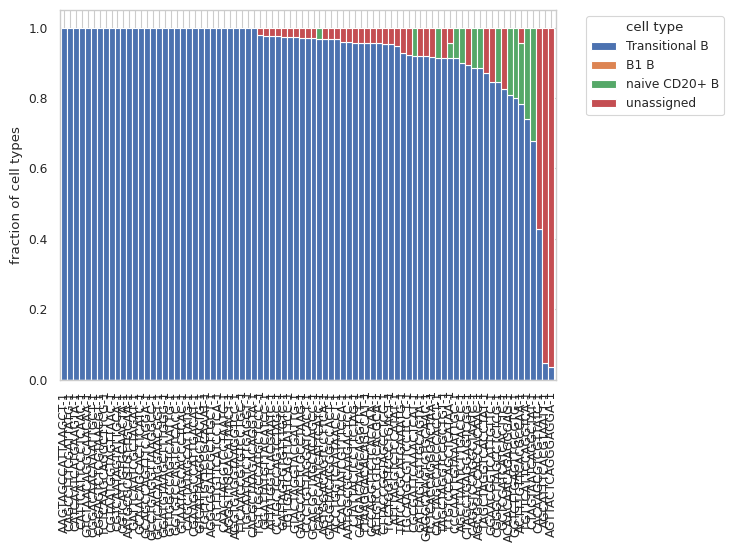

In [467]:
# joint
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

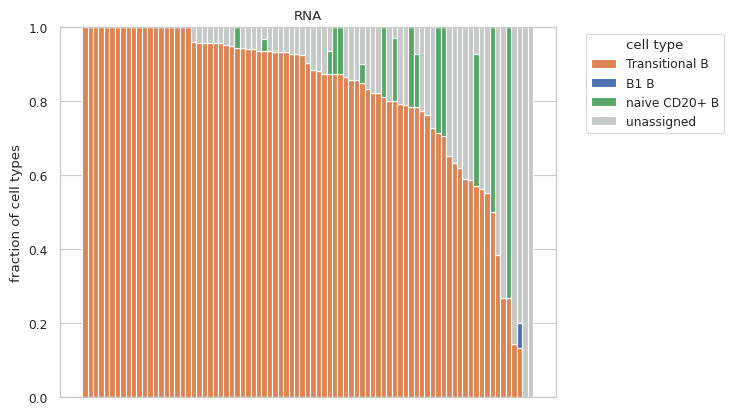

In [486]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots()
ax.bar(df_sorted.index,transB, color="#dd8452", width=1,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=1, 
       label="naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned")
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("RNA")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_RNA_stacked_bars.pdf")
plt.show()

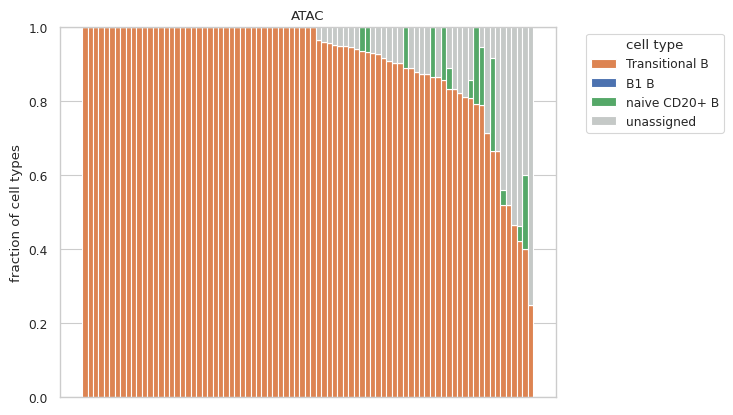

In [485]:
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots()
ax.bar(df_sorted.index,transB, color="#dd8452", width=1,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=1, 
       label="naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned")
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("ATAC")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_ATAC_stacked_bars.pdf")
plt.show()

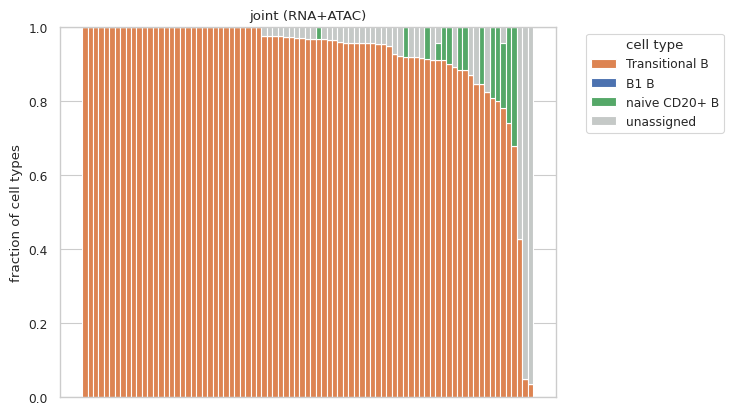

In [487]:
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots()
ax.bar(df_sorted.index,transB, color="#dd8452", width=1,label="Transitional B")
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B")
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#55a868", width=1, 
       label="naive CD20+ B")
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned")
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("joint (RNA+ATAC)")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_joint_stacked_bars.pdf")
plt.show()